# Task 1

## Lib & Dependencies

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
import plotly.graph_objects as go

In [2]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

## Import Data

In [3]:
POI_A = pd.read_csv('data/POIdata_cityA.csv')
POI_B = pd.read_csv('data/POIdata_cityB.csv')
POI_C = pd.read_csv('data/POIdata_cityC.csv')
POI_D = pd.read_csv('data/POIdata_cityD.csv')
POI_categories = pd.read_csv('data/POI_datacategories.csv',header=None)

In [149]:
POI_categories

,0
0,Food
1,Shopping
2,Entertainment
3,Japanese restaurant
4,Western restaurant
...,...
80,Heavy Industry
81,NPO
82,Utility Copany
83,Port


In [4]:
# zero-indexing
POI_B['category'] = POI_B['category']-1
POI_A['category'] = POI_A['category']-1
POI_C['category'] = POI_C['category']-1
POI_D['category'] = POI_D['category']-1

In [5]:
len(POI_A['category'].unique())

85

## Apriori

### A

In [197]:
def create_onehot_df(POI_,show_basket=False):
    print("df size:",POI_.shape[0])
    
    # create basket for each pair of x,y
    grouped = POI_.groupby(['x', 'y'])['category'].apply(list).reset_index()
    print(f"mean len of basket = {grouped['category'].apply(len).mean()}")
    print(f"max len of basket = {grouped['category'].apply(len).max()}")
    print("number of transactions =",grouped.shape[0])
    
    if show_basket:
        print(grouped)
    
    # Prepare transactions for Apriori.
    transactions = grouped['category'].tolist()
    
    encoder = TransactionEncoder()
    onehot = encoder.fit(transactions).transform(transactions)
    return pd.DataFrame(onehot, columns=encoder.columns_)

onehot_dfA = create_onehot_df(POI_A,True)

df size: 221248
mean len of basket = 10.98222972302194
max len of basket = 76
number of transactions = 20146
         x    y                                           category
0        1    1                       [73, 47, 78, 68, 72, 58, 57]
1        1    2                               [60, 79, 47, 75, 59]
2        1    3           [73, 80, 47, 81, 53, 55, 57, 72, 35, 59]
3        1    4                       [72, 80, 62, 47, 78, 73, 68]
4        1    5                       [73, 59, 47, 68, 61, 75, 78]
...    ...  ...                                                ...
20141  200  196                                       [37, 47, 68]
20142  200  197                                [3, 83, 65, 75, 46]
20143  200  198    [80, 60, 47, 56, 33, 78, 6, 38, 12, 55, 68, 17]
20144  200  199  [57, 4, 58, 68, 47, 73, 56, 21, 80, 59, 3, 12,...
20145  200  200  [73, 46, 80, 74, 78, 77, 44, 59, 75, 58, 40, 6...

[20146 rows x 3 columns]


In [199]:
# calculate avg support
def calc_avg_sup(onehot_df):
    sum = 0
    num_transactions = onehot_df.shape[0]
    num_items = onehot_df.shape[1]
    
    for col in onehot_df.columns:
        S = onehot_df[col].sum()/num_transactions
        sum = sum + S*1
    avg_sup = sum/num_items
    
    print(f'Average support: {avg_sup:.4f}')

calc_avg_sup(onehot_dfA)

Average support: 0.1292


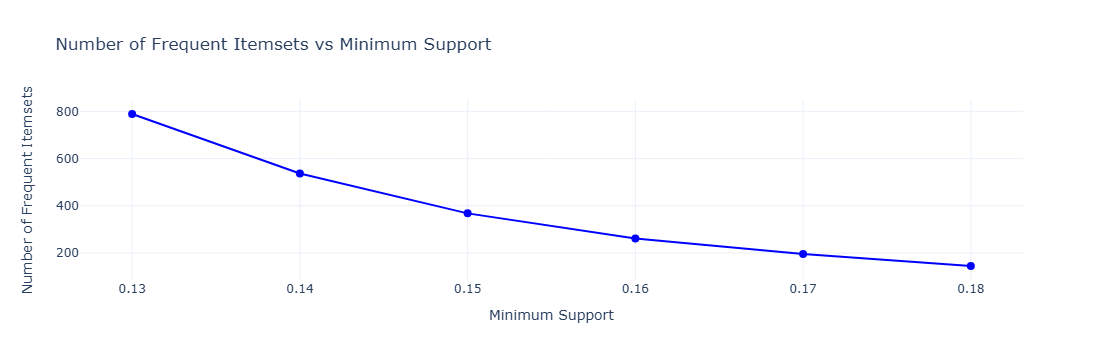

In [221]:
def plot_support_vs_frequent_itemsets(onehot_df,start_idx,end_idx):
    support_values = []
    frequent_itemsets_counts = []
    
    # Loop over the support thresholds with an increment of 0.01
    for x in [i/100 for i in range(start_idx, end_idx)]:
        frequent_itemsets = apriori(onehot_df, min_support=x, use_colnames=True)
        
        # Append the current support value and the number of frequent itemsets
        support_values.append(x)
        frequent_itemsets_counts.append(len(frequent_itemsets))
    
    fig = go.Figure()

    # Add a scatter plot for the data
    fig.add_trace(go.Scatter(
        x=support_values, 
        y=frequent_itemsets_counts, 
        mode='markers+lines',
        marker=dict(color='blue', size=8),
        line=dict(color='blue', width=2),
        name='Frequent Itemsets'
    ))

    # Customize the layout of the plot
    fig.update_layout(
        title='Number of Frequent Itemsets vs Minimum Support',
        xaxis_title='Minimum Support',
        yaxis_title='Number of Frequent Itemsets',
        template='plotly_white',
        showlegend=False,
        xaxis=dict(tickmode='array', tickvals=support_values),
        plot_bgcolor='white',
        width=400
    )
    fig.show()

plot_support_vs_frequent_itemsets(onehot_dfA,13,19)

In [223]:
frequent_itemsetsA = apriori(onehot_dfA, min_support=0.15, use_colnames=True)
frequent_itemsetsA

,support,itemsets
0,0.241934,(3)
1,0.255932,(17)
2,0.152388,(32)
3,0.171945,(35)
4,0.186538,(37)
...,...,...
363,0.179837,"(80, 59, 68, 78)"
364,0.162216,"(80, 59, 75, 78)"
365,0.165790,"(80, 68, 61, 78)"
366,0.157947,"(80, 75, 68, 78)"


In [225]:
# remove frequent itemsets that is subsets of larger itemsets
def filter_subsets(frequent_itemsets):
    frequent_itemsets = frequent_itemsets.sort_values(by='itemsets', key=lambda x: x.apply(len), ascending=False)
    filtered_itemsets = []
    
    for index, row in frequent_itemsets.iterrows():
        itemset = row['itemsets']
        if not any(itemset < larger_itemset for larger_itemset in filtered_itemsets):
            filtered_itemsets.append(itemset)
    
    return frequent_itemsets[frequent_itemsets['itemsets'].isin(filtered_itemsets)]

filtered_frequent_itemsetsA = filter_subsets(frequent_itemsetsA)
filtered_frequent_itemsetsA

,support,itemsets
367,0.156110,"(68, 78, 80, 58, 59)"
342,0.153926,"(59, 58, 75, 68)"
341,0.161819,"(80, 58, 59, 61)"
340,0.159883,"(58, 59, 61, 78)"
339,0.162464,"(58, 59, 68, 61)"
...,...,...
12,0.168123,(56)
3,0.171945,(35)
2,0.152388,(32)
16,0.177504,(60)


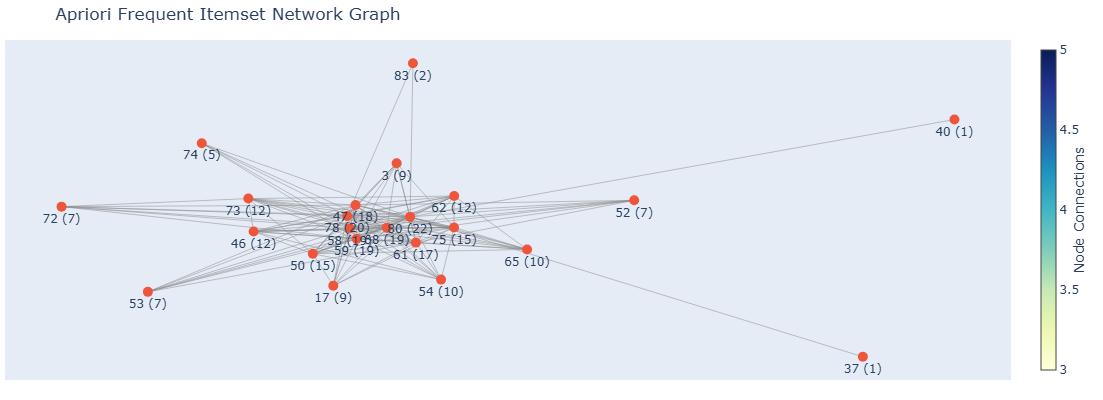

In [227]:
def plot_nx_graph(frequent_itemsets):
    G = nx.Graph()
    
    # Add edges to the graph based on itemsets
    for _, row in frequent_itemsets.iterrows():
        itemset = row['itemsets']
        support = row['support']
        for item1 in itemset:
            for item2 in itemset:
                if item1 != item2:
                    if G.has_edge(item1, item2):
                        # Update the support weight if the edge already exists (for multiple itemsets containing the same items)
                        G[item1][item2]['weight'] += support
                    else:
                        G.add_edge(item1, item2, weight=support)
    
    # Extract the positions of nodes using NetworkX's spring layout for a nicer visualization
    pos = nx.spring_layout(G, seed=42)
    
    # Plotly setup to create scatter plots for the nodes and edges
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]
    
    # Plot edges
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')
    
    # Plot nodes
    node_x = []
    node_y = []
    node_text = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        # Display the node and its degree as text
        node_text.append(f'{node} ({G.degree[node]})')
    
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,
        textposition="bottom center",
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
        ))
    
    # Combine both traces into a single figure
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='Apriori Frequent Itemset Network Graph',
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        width=600,
                        height=400
                    )
                   )
    
    fig.show()

plot_nx_graph(frequent_itemsetsA)

In [229]:
def print_frequent_itemsets(frequent_itemsets,show_support=False):
    count = 0
    # order by support in descending order
    for idx, row in frequent_itemsets.sort_values('support',ascending=False).iterrows():
        count = count + 1
        names = []
        idx = []
        items = row['itemsets']
        # print top 50 rows
        if count == 50:
            break
        for i in items:
            names.append(POI_categories.loc[i, 0])
            idx.append(i)
            
        if len(names) >= 4:
            # If there are 4 or more names, split into two lines
            mid_point = len(names) // 2
            first_line = ", ".join(names[:mid_point])
            second_line = ", ".join(names[mid_point:])
            
            print(first_line)
            if show_support:
                print(second_line, ':',round(row['support'], 4))
            else:
                print(second_line)
        else:
            # If there are fewer than 4 names, print in one line
            if show_support:
                print(", ".join(names), ':',round(row['support'], 4))
            else:
                print(", ".join(names))
        print('----------------------------------------------')

In [231]:
# Itemsets with largest number of items
frequent_itemsetsA_ = filtered_frequent_itemsetsA[filtered_frequent_itemsetsA['itemsets'].apply(len)==5]
print_frequent_itemsets(frequent_itemsetsA_)
frequent_itemsetsA_ = filtered_frequent_itemsetsA[filtered_frequent_itemsetsA['itemsets'].apply(len)==4]
print_frequent_itemsets(frequent_itemsetsA_)

Hair Salon, Building Material
Heavy Industry, Real Estate, Home Appliances
----------------------------------------------
Heavy Industry, Real Estate
Hair Salon, Laundry 
----------------------------------------------
Real Estate, Hair Salon
Laundry , Building Material
----------------------------------------------
Heavy Industry, Real Estate
Laundry , Building Material
----------------------------------------------
Heavy Industry, Real Estate
Building Material, Transit Station
----------------------------------------------
Heavy Industry, Real Estate
Accountant Office, Building Material
----------------------------------------------
Heavy Industry, Hair Salon
Laundry , Building Material
----------------------------------------------
Real Estate, Hair Salon
Building Material, Transit Station
----------------------------------------------
Heavy Industry, Real Estate
Hair Salon, Transit Station
----------------------------------------------
Heavy Industry, Home Appliances
Building Materi

In [81]:
# Itemsets with highest support (after filtered)
print_frequent_itemsets(filtered_frequent_itemsetsA,True)

Community Center, Heavy Industry : 0.1914
----------------------------------------------
Heavy Industry, Church, Home Appliances : 0.1862
----------------------------------------------
Heavy Industry, Elderly Care Home : 0.1858
----------------------------------------------
Heavy Industry, Church, Building Material : 0.1844
----------------------------------------------
Heavy Industry, Port : 0.1822
----------------------------------------------
Community Center, Home Appliances : 0.1796
----------------------------------------------
Bank, Transit Station : 0.178
----------------------------------------------
Elderly Care Home, Building Material : 0.1778
----------------------------------------------
Heavy Industry, Chiropractic : 0.1776
----------------------------------------------
Post Office : 0.1775
----------------------------------------------
Church, Park : 0.1768
----------------------------------------------
Heavy Industry, Park, Building Material : 0.1765
-------------------

In [83]:
# POIs with lowest degree
frequent_itemsetsA_ = filtered_frequent_itemsetsA[filtered_frequent_itemsetsA['itemsets'].apply(lambda x: any(item in x for item in [37, 40, 83]))]
print_frequent_itemsets(frequent_itemsetsA_,True)

Heavy Industry, Port : 0.1822
----------------------------------------------
Heavy Industry, Interior Shop : 0.1563
----------------------------------------------
Grocery Store, Heavy Industry : 0.1532
----------------------------------------------
Port, Building Material : 0.1525
----------------------------------------------


In [85]:
# 1-Itemsets (POIs that do not co-occur frequently with other POI)
filtered_frequent_itemsetsA_1 = filtered_frequent_itemsetsA[filtered_frequent_itemsetsA['itemsets'].apply(len)==1]

for idx, row in filtered_frequent_itemsetsA_1.sort_values('support',ascending=False).iterrows():
    names = []
    idx = []
    items = row['itemsets']
    for i in items:
        names.append(POI_categories.loc[i, 0])
        idx.append(i)
    print(", ".join(names))

Post Office
Convenience Store
Cram School
Kindergarten
NPO
Drug Store


### B

In [87]:
onehot_dfB = create_onehot_df(POI_B)

df size: 56181
mean len of basket = 6.1574967119684345
max len of basket = 76
number of transactions = 9124


In [89]:
calc_avg_sup(onehot_dfB)

Average support: 0.0733


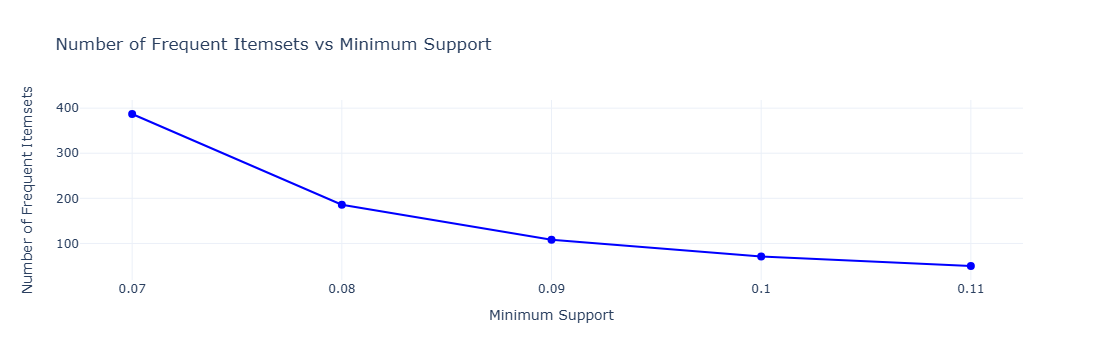

In [91]:
plot_support_vs_frequent_itemsets(onehot_dfB,7,12)

In [107]:
frequent_itemsetsB = apriori(onehot_dfB, min_support=0.08, use_colnames=True)
frequent_itemsetsB

,support,itemsets
0,0.130864,(3)
1,0.081214,(17)
2,0.084174,(35)
3,0.107080,(37)
4,0.140728,(40)
...,...,...
181,0.093161,"(80, 68, 78)"
182,0.094695,"(80, 75, 78)"
183,0.080666,"(58, 59, 78, 47)"
184,0.080886,"(59, 68, 78, 47)"


In [109]:
filtered_frequent_itemsetsB = filter_subsets(frequent_itemsetsB)
filtered_frequent_itemsetsB

,support,itemsets
185,0.083735,"(80, 59, 78, 47)"
184,0.080886,"(59, 68, 78, 47)"
183,0.080666,"(58, 59, 78, 47)"
146,0.084064,"(80, 62, 47)"
141,0.090859,"(68, 61, 47)"
...,...,...
8,0.091517,(52)
2,0.084174,(35)
1,0.081214,(17)
25,0.113985,(81)


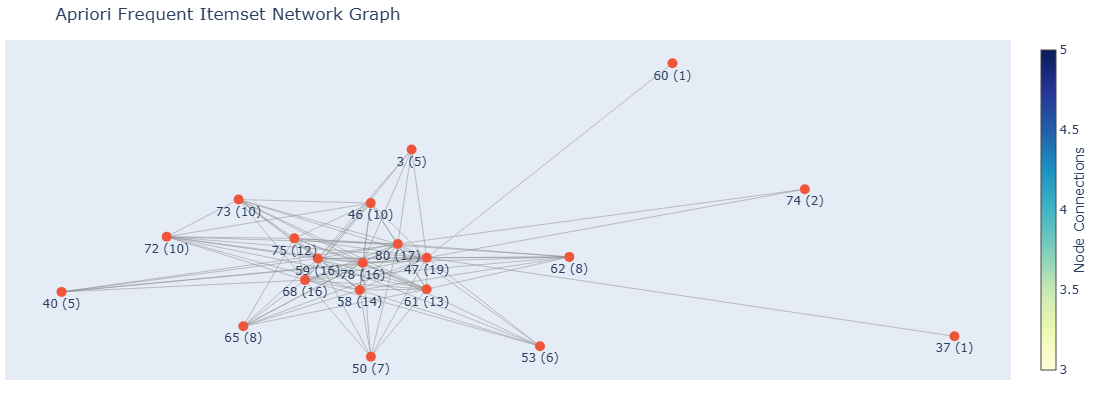

In [111]:
plot_nx_graph(frequent_itemsetsB)

In [115]:
# Itemsets with largest number of items
frequent_itemsetsB_ = filtered_frequent_itemsetsB[filtered_frequent_itemsetsB['itemsets'].apply(len)==4]
print_frequent_itemsets(frequent_itemsetsB_)
frequent_itemsetsB_ = filtered_frequent_itemsetsB[filtered_frequent_itemsetsB['itemsets'].apply(len)==3]
print_frequent_itemsets(frequent_itemsetsB_)

Heavy Industry, Home Appliances
Building Material, Transit Station
----------------------------------------------
Home Appliances, Hair Salon
Building Material, Transit Station
----------------------------------------------
Real Estate, Home Appliances
Building Material, Transit Station
----------------------------------------------
Heavy Industry, Hair Salon, Transit Station
----------------------------------------------
Accountant Office, Home Appliances, Building Material
----------------------------------------------
Accountant Office, Building Material, Transit Station
----------------------------------------------
Heavy Industry, Accountant Office, Building Material
----------------------------------------------
Heavy Industry, Hair Salon, Building Material
----------------------------------------------
Heavy Industry, Accountant Office, Transit Station
----------------------------------------------
Heavy Industry, Home Appliances, Hair Salon
-------------------------------------

In [117]:
# Itemsets with highest support (after filtered)
print_frequent_itemsets(filtered_frequent_itemsetsB,True)

Port : 0.128
----------------------------------------------
Heavy Industry, Church : 0.1215
----------------------------------------------
Church, Home Appliances : 0.1179
----------------------------------------------
Community Center, Church : 0.1178
----------------------------------------------
NPO : 0.114
----------------------------------------------
Community Center, Home Appliances : 0.1075
----------------------------------------------
Heavy Industry, Community Center : 0.1069
----------------------------------------------
Church, Hair Salon : 0.1046
----------------------------------------------
Grocery Store, Transit Station : 0.1007
----------------------------------------------
Fishing : 0.1
----------------------------------------------
Kindergarten : 0.1
----------------------------------------------
Community Center, Hair Salon : 0.0986
----------------------------------------------
Home Appliances, Driving School : 0.0986
----------------------------------------------


In [119]:
# POIs with lowest degree
frequent_itemsetsB_ = filtered_frequent_itemsetsB[filtered_frequent_itemsetsB['itemsets'].apply(lambda x: any(item in x for item in [37, 60, 74]))]
print_frequent_itemsets(frequent_itemsetsB_,True)

Heavy Industry, Retail Store : 0.0843
----------------------------------------------
Interior Shop, Transit Station : 0.0826
----------------------------------------------
Retail Store, Transit Station : 0.0819
----------------------------------------------
Post Office, Transit Station : 0.0804
----------------------------------------------


In [121]:
# 1-Itemsets (POIs that do not co-occur frequently with other POI)
filtered_frequent_itemsetsB_1 = filtered_frequent_itemsetsB[filtered_frequent_itemsetsB['itemsets'].apply(len)==1]

for idx, row in filtered_frequent_itemsetsB_1.sort_values('support',ascending=False).iterrows():
    names = []
    idx = []
    items = row['itemsets']
    for i in items:
        names.append(POI_categories.loc[i, 0])
        idx.append(i)
    print(", ".join(names))

Port
NPO
Kindergarten
Fishing
Chiropractic
Convenience Store
Café


In [277]:
POI_C.shape[0]

39064

In [266]:
grouped = POI_C.groupby(['x', 'y'])['category'].apply(list).reset_index()
# len(POI_A[POI_A['category']==4]['x'])/grouped.shape[0]
print(f"mean len = {grouped['category'].apply(len).mean()}")
print(f"max len = {grouped['category'].apply(len).max()}")
print(grouped.shape[0])

mean len = 12.015995078437404
max len = 75
3251


In [268]:
# Prepare transactions for Apriori.
transactions = grouped['category'].tolist()

encoder = TransactionEncoder()
onehot = encoder.fit(transactions).transform(transactions)
onehot_df = pd.DataFrame(onehot, columns=encoder.columns_)

In [270]:
total_entries = onehot_df.shape[0] * onehot_df.shape[1]  # rows * columns

# Count non-zero entries (i.e., presence of items)
non_zero_entries = onehot_df.sum().sum()  # sum across all items and transactions

# Calculate density
density = non_zero_entries / total_entries

# Display the density
print(f'Density: {density:.4f}')

sum = 0
for col in onehot_df.columns:
    sum = sum + onehot_df[col].sum()/onehot_df.shape[0]

avg_sup = sum/onehot_df.shape[1]
min_sup = avg_sup/onehot_df.shape[0]
min_sup

Density: 0.1414


4.348343524503737e-05

In [272]:
frequent_itemsetsC = apriori(onehot_df, min_support=0.14, use_colnames=True)
frequent_itemsetsC

,support,itemsets
0,0.234697,(4)
1,0.151030,(9)
2,0.193787,(18)
3,0.185174,(21)
4,0.154414,(33)
...,...,...
3320,0.144263,"(66, 69, 79, 48, 47, 59, 60)"
3321,0.150723,"(69, 76, 79, 48, 47, 59, 60)"
3322,0.143033,"(69, 79, 48, 81, 47, 59, 60)"
3323,0.143956,"(69, 76, 79, 48, 47, 59, 62)"


In [274]:
filtered_frequent_itemsetsC = filter_subsets(frequent_itemsetsC)
filtered_frequent_itemsetsC

,support,itemsets
3324,0.142110,"(66, 69, 76, 47, 48, 79, 59)"
3317,0.143341,"(69, 76, 79, 48, 47, 54, 59)"
3311,0.142418,"(69, 79, 48, 47, 51, 54, 59)"
3312,0.144878,"(69, 79, 48, 47, 51, 59, 60)"
3313,0.142418,"(69, 79, 48, 47, 51, 59, 62)"
...,...,...
185,0.143648,"(75, 55)"
191,0.140265,"(57, 76)"
14,0.159336,(56)
26,0.146109,(73)


In [ ]:
frequent_itemsetsC_4 = filtered_frequent_itemsetsC[filtered_frequent_itemsetsC['itemsets'].apply(len)==4]
print(frequent_itemsetsC_4.apply(len))
exploded_items = frequent_itemsetsB_4['itemsets'].explode()

item_counts = exploded_items.value_counts()
item_counts

In [ ]:
frequent_itemsetsB_4 = frequent_itemsetsB_4.sort_values(
    by='itemsets', 
    key=lambda x: x.apply(lambda itemset: 48 in itemset), 
    ascending=False
)
print('-----------------------------------------------')
for item in frequent_itemsetsB_4['itemsets']:
    names = []
    for i in item:
        # Append the name directly to the list
        names.append(POI_categories.loc[i-1, 0])  # Assuming the name is in the first column
    # Join the names into a single string
    print(", ".join(names))
    print('')
    print('----------------------------------------------')

In [296]:
POI_D.shape[0]

72794

### C

In [127]:
onehot_dfC = create_onehot_df(POI_C)

df size: 39064
mean len of basket = 12.015995078437404
max len of basket = 75
number of transactions = 3251


In [129]:
calc_avg_sup(onehot_dfC)

Average support: 0.1414


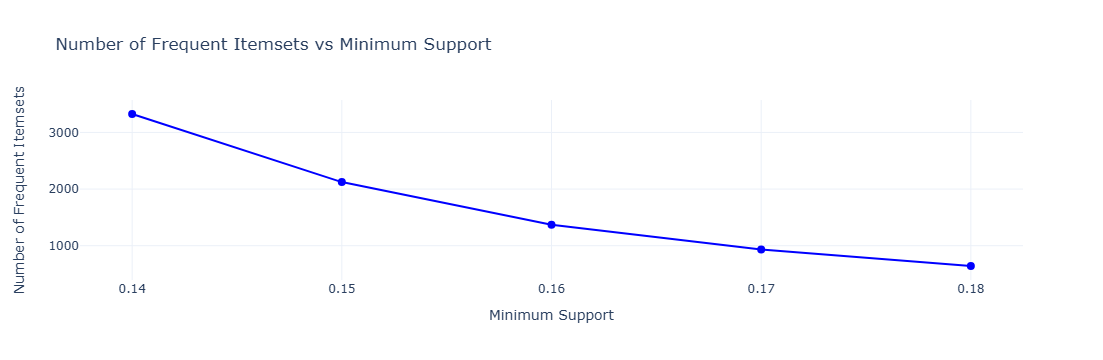

In [131]:
plot_support_vs_frequent_itemsets(onehot_dfC,14,19)

In [133]:
frequent_itemsetsC = apriori(onehot_dfC, min_support=0.17, use_colnames=True)
frequent_itemsetsC

,support,itemsets
0,0.234697,(3)
1,0.193787,(17)
2,0.185174,(20)
3,0.250384,(35)
4,0.253153,(37)
...,...,...
928,0.173177,"(75, 78, 47, 80, 59)"
929,0.170102,"(68, 75, 78, 58, 59)"
930,0.176869,"(68, 78, 46, 47, 58, 59)"
931,0.171639,"(75, 78, 46, 47, 58, 59)"


In [135]:
filtered_frequent_itemsetsC = filter_subsets(frequent_itemsetsC)
filtered_frequent_itemsetsC

,support,itemsets
932,0.173485,"(68, 75, 78, 46, 47, 58)"
931,0.171639,"(75, 78, 46, 47, 58, 59)"
930,0.176869,"(68, 78, 46, 47, 58, 59)"
861,0.170409,"(65, 46, 47, 58, 61)"
862,0.186404,"(68, 46, 47, 58, 61)"
...,...,...
5,0.191018,(40)
2,0.185174,(20)
1,0.193787,(17)
21,0.176869,(69)


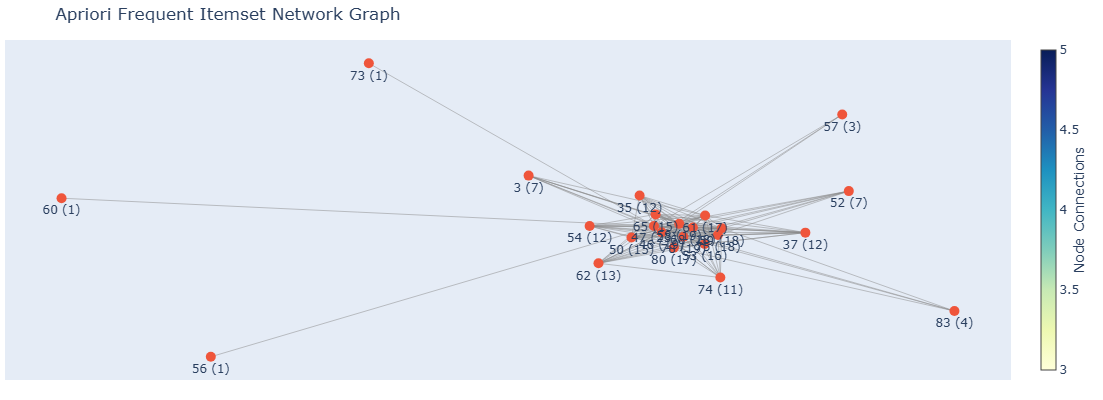

In [137]:
plot_nx_graph(frequent_itemsetsC)

In [139]:
# Itemsets with largest number of items
frequent_itemsetsC_ = filtered_frequent_itemsetsC[filtered_frequent_itemsetsC['itemsets'].apply(len)==6]
print_frequent_itemsets(frequent_itemsetsC_)
frequent_itemsetsC_ = filtered_frequent_itemsetsC[filtered_frequent_itemsetsC['itemsets'].apply(len)==5]
print_frequent_itemsets(frequent_itemsetsC_)

Hair Salon, Building Material, Park
Transit Station, Real Estate, Home Appliances
----------------------------------------------
Hair Salon, Accountant Office, Building Material
Park, Transit Station, Real Estate
----------------------------------------------
Accountant Office, Building Material, Park
Transit Station, Real Estate, Home Appliances
----------------------------------------------
Park, Building Material
Transit Station, Elderly Care Home, Real Estate
----------------------------------------------
Hair Salon, Park
Transit Station, Hospital, Real Estate
----------------------------------------------
Park, Building Material
Heavy Industry, Transit Station, Real Estate
----------------------------------------------
Park, Building Material
Transit Station, Hospital, Real Estate
----------------------------------------------
Hair Salon, Park
Transit Station, Elderly Care Home, Real Estate
----------------------------------------------
Park, Building Material
Transit Station, Rea

In [141]:
# Itemsets with highest support (after filtered)
print_frequent_itemsets(filtered_frequent_itemsetsC,True)

Park, Building Material
Transit Station, Elderly Care Home, Real Estate : 0.1944
----------------------------------------------
Café : 0.1938
----------------------------------------------
Heavy Industry, Driving School, Transit Station : 0.1938
----------------------------------------------
Retail Store, Park, Transit Station : 0.1926
----------------------------------------------
Heavy Industry, Driving School, Building Material : 0.1916
----------------------------------------------
Hair Salon, Park
Transit Station, Hospital, Real Estate : 0.1913
----------------------------------------------
Kindergarten, Transit Station : 0.1913
----------------------------------------------
Port, Transit Station : 0.191
----------------------------------------------
Grocery Store : 0.191
----------------------------------------------
Park, Building Material
Heavy Industry, Transit Station, Real Estate : 0.1898
----------------------------------------------
Park, Building Material
Transit Station,

In [145]:
# POIs with lowest degree
frequent_itemsetsC_ = filtered_frequent_itemsetsC[filtered_frequent_itemsetsC['itemsets'].apply(lambda x: any(item in x for item in [56, 57, 60, 73]))]
print_frequent_itemsets(frequent_itemsetsC_,True)

Kindergarten, Transit Station : 0.1913
----------------------------------------------
Post Office, Transit Station : 0.1861
----------------------------------------------
Church, Transit Station : 0.1799
----------------------------------------------
Kindergarten, Real Estate : 0.179
----------------------------------------------
Kindergarten, Park : 0.1787
----------------------------------------------
Cram School, Transit Station : 0.1704
----------------------------------------------


In [147]:
# 1-Itemsets (POIs that do not co-occur frequently with other POI)
filtered_frequent_itemsetsC_1 = filtered_frequent_itemsetsC[filtered_frequent_itemsetsC['itemsets'].apply(len)==1]

for idx, row in filtered_frequent_itemsetsC_1.sort_values('support',ascending=False).iterrows():
    names = []
    idx = []
    items = row['itemsets']
    for i in items:
        names.append(POI_categories.loc[i, 0])
        idx.append(i)
    print(", ".join(names))

Café
Grocery Store
Sweets 
Lawyer Office
NPO


### D

In [149]:
onehot_dfD = create_onehot_df(POI_D)

df size: 72794
mean len of basket = 6.6248634874408445
max len of basket = 74
number of transactions = 10988


In [150]:
calc_avg_sup(onehot_dfD)

Average support: 0.0789


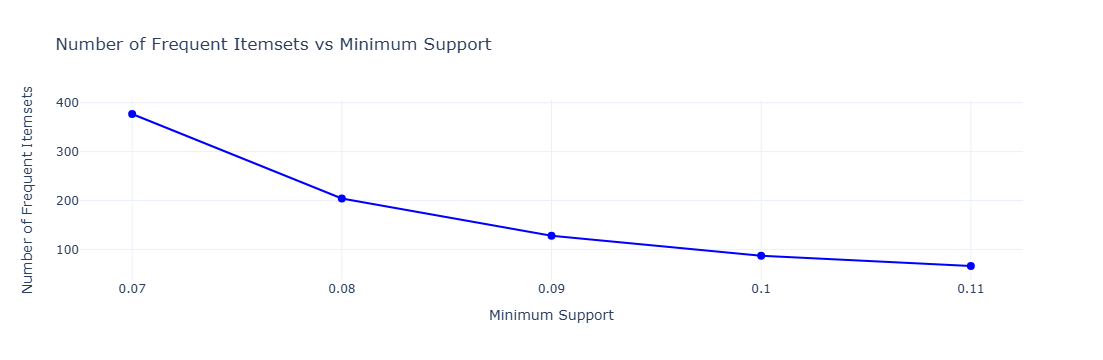

In [153]:
plot_support_vs_frequent_itemsets(onehot_dfD,7,12)

In [157]:
frequent_itemsetsD = apriori(onehot_dfD, min_support=0.07, use_colnames=True)
frequent_itemsetsD

,support,itemsets
0,0.138151,(3)
1,0.072898,(17)
2,0.074172,(20)
3,0.072352,(32)
4,0.085184,(35)
...,...,...
372,0.074081,"(80, 59, 68, 78)"
373,0.072443,"(80, 75, 59, 78)"
374,0.070531,"(80, 75, 68, 61)"
375,0.074900,"(80, 68, 61, 78)"


In [159]:
filtered_frequent_itemsetsD = filter_subsets(frequent_itemsetsD)
filtered_frequent_itemsetsD

,support,itemsets
376,0.072534,"(80, 75, 68, 78)"
366,0.073626,"(75, 68, 78, 47)"
358,0.070167,"(58, 68, 61, 47)"
359,0.070258,"(58, 68, 78, 47)"
360,0.072716,"(59, 68, 78, 47)"
...,...,...
3,0.072352,(32)
2,0.074172,(20)
1,0.072898,(17)
18,0.095741,(60)


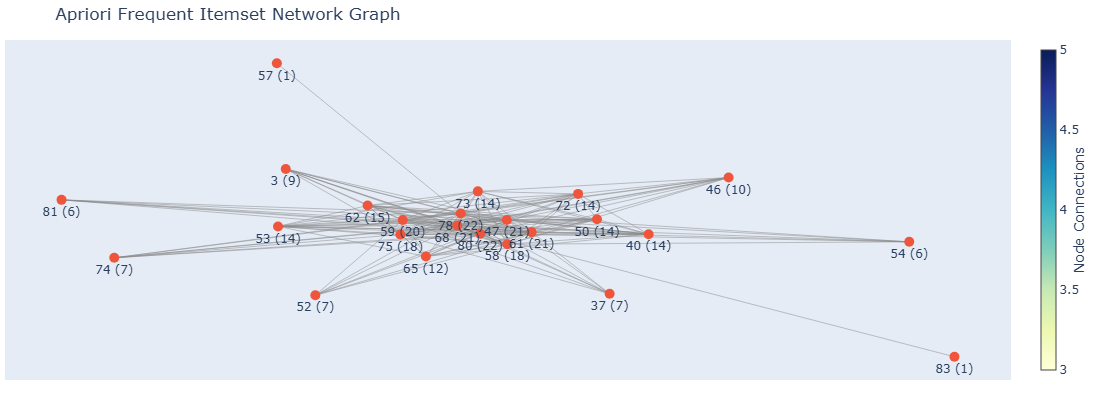

In [161]:
plot_nx_graph(frequent_itemsetsD)

In [163]:
# Itemsets with largest number of items
frequent_itemsetsD_ = filtered_frequent_itemsetsD[filtered_frequent_itemsetsD['itemsets'].apply(len)==4]
print_frequent_itemsets(frequent_itemsetsD_)

Heavy Industry, Hair Salon
Building Material, Transit Station
----------------------------------------------
Heavy Industry, Hair Salon
Laundry , Transit Station
----------------------------------------------
Hair Salon, Laundry 
Building Material, Transit Station
----------------------------------------------
Heavy Industry, Hair Salon
Laundry , Building Material
----------------------------------------------
Heavy Industry, Home Appliances
Building Material, Transit Station
----------------------------------------------
Heavy Industry, Home Appliances
Hair Salon, Building Material
----------------------------------------------
Heavy Industry, Accountant Office
Building Material, Transit Station
----------------------------------------------
Accountant Office, Hair Salon
Building Material, Transit Station
----------------------------------------------
Heavy Industry, Laundry 
Building Material, Transit Station
----------------------------------------------
Accountant Office, Hair Salo

In [165]:
# Itemsets with highest support (after filtered)
print_frequent_itemsets(filtered_frequent_itemsetsD,True)

Grocery Store, Church : 0.099
----------------------------------------------
Post Office : 0.0957
----------------------------------------------
Heavy Industry, Retail Store : 0.0924
----------------------------------------------
Church, Driving School : 0.0918
----------------------------------------------
Japanese restaurant, Transit Station : 0.0911
----------------------------------------------
Driving School, Heavy Industry, Building Material : 0.09
----------------------------------------------
Church, Real Estate : 0.0892
----------------------------------------------
Heavy Industry, Japanese restaurant : 0.0889
----------------------------------------------
Accountant Office, Elderly Care Home : 0.0888
----------------------------------------------
Community Center, Laundry  : 0.0876
----------------------------------------------
Church, Home Appliances, Building Material : 0.0875
----------------------------------------------
Home Appliances, Laundry , Building Material : 0.08

In [167]:
# POIs with lowest degree
frequent_itemsetsD_ = filtered_frequent_itemsetsD[filtered_frequent_itemsetsD['itemsets'].apply(lambda x: any(item in x for item in [57, 83]))]
print_frequent_itemsets(frequent_itemsetsD_,True)

Heavy Industry, Port : 0.0765
----------------------------------------------
Kindergarten, Building Material : 0.0703
----------------------------------------------


In [169]:
# 1-Itemsets (POIs that do not co-occur frequently with other POI)
filtered_frequent_itemsetsD_1 = filtered_frequent_itemsetsD[filtered_frequent_itemsetsD['itemsets'].apply(len)==1]

for idx, row in filtered_frequent_itemsetsD_1.sort_values('support',ascending=False).iterrows():
    names = []
    idx = []
    items = row['itemsets']
    for i in items:
        names.append(POI_categories.loc[i, 0])
        idx.append(i)
    print(", ".join(names))

Post Office
Convenience Store
Gardening
Clothes Store
School
Sweets 
Café
Drug Store


In [276]:
grouped = POI_D.groupby(['x', 'y'])['category'].apply(list).reset_index()
# len(POI_A[POI_A['category']==4]['x'])/grouped.shape[0]
print(f"mean len = {grouped['category'].apply(len).mean()}")
print(f"max len = {grouped['category'].apply(len).max()}")
print(grouped.shape[0])

mean len = 6.6248634874408445
max len = 74
10988


In [277]:
# Prepare transactions for Apriori.
transactions = grouped['category'].tolist()

encoder = TransactionEncoder()
onehot = encoder.fit(transactions).transform(transactions)
onehot_df = pd.DataFrame(onehot, columns=encoder.columns_)

In [280]:
total_entries = onehot_df.shape[0] * onehot_df.shape[1]  # rows * columns

# Count non-zero entries (i.e., presence of items)
non_zero_entries = onehot_df.sum().sum()  # sum across all items and transactions

# Calculate density
density = non_zero_entries / total_entries

# Display the density
print(f'Density: {density:.4f}')

sum = 0
for col in onehot_df.columns:
    sum = sum + onehot_df[col].sum()/onehot_df.shape[0]

avg_sup = sum/onehot_df.shape[1]
min_sup = avg_sup/onehot_df.shape[0]
min_sup

Density: 0.0789


7.177595783539669e-06

In [282]:
frequent_itemsetsD = apriori(onehot_df, min_support=0.07, use_colnames=True)
frequent_itemsetsD

,support,itemsets
0,0.138151,(4)
1,0.072898,(18)
2,0.074172,(21)
3,0.072352,(33)
4,0.085184,(36)
...,...,...
372,0.074081,"(81, 60, 69, 79)"
373,0.072443,"(81, 60, 76, 79)"
374,0.070531,"(81, 76, 69, 62)"
375,0.074900,"(81, 69, 62, 79)"


In [ ]:
filtered_frequent_itemsetsC = filter_subsets(frequent_itemsetsC)
filtered_frequent_itemsetsC

In [ ]:
frequent_itemsetsC_4 = filtered_frequent_itemsetsC[filtered_frequent_itemsetsC['itemsets'].apply(len)==4]
print(frequent_itemsetsC_4.apply(len))
exploded_items = frequent_itemsetsB_4['itemsets'].explode()

item_counts = exploded_items.value_counts()
item_counts

In [ ]:
frequent_itemsetsB_4 = frequent_itemsetsB_4.sort_values(
    by='itemsets', 
    key=lambda x: x.apply(lambda itemset: 48 in itemset), 
    ascending=False
)
print('-----------------------------------------------')
for item in frequent_itemsetsB_4['itemsets']:
    names = []
    for i in item:
        # Append the name directly to the list
        names.append(POI_categories.loc[i-1, 0])  # Assuming the name is in the first column
    # Join the names into a single string
    print(", ".join(names))
    print('')
    print('----------------------------------------------')